In [21]:
import numpy
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [127]:
def tanh(x):
    return (1.0 - numpy.exp(-2*x))/(1.0 + numpy.exp(-2*x))
# Prove this
# f: tanh then f'(x) = (1+f(x))*(1-f(x))
def tanh_derivative(y):
    return (1 + y)*(1 - y)

In [137]:
def CrossEntropy(yHat, y):
    if y == 1:
        return -np.log2(yHat)
    else:
        return -np.log2(1 - yHat)

In [5]:
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))
# Prove this
# f: sigmoid then f'(x) = f(x)(1 - f(x))
def sigmoid_derivative(y):
    return y * (1 - y)

In [6]:
def sample_points(n):
    radius = np.random.uniform(low = 0, high = 2, size = n).reshape(-1,1)
    angle = np.random.uniform(low = 0, high = 2*np.pi, size = n).reshape(-1,1)
    x1 = radius*np.cos(angle)
    x2 = radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2], axis = 1)
    return x,y

In [138]:
class my_MLP:
    #########
    # parameters
    # ----------
    # self:      the class object itself
    # net_arch:  consists of a list of integers, indicating
    #            the number of neurons in each layer, i.e. the network architecture
    #########
    def __init__(self, net_arch=[2, 6, 1]):
        numpy.random.seed(0)
        
        # Initialized the weights, making sure we also 
        # initialize the weights for the biases that we will add later
        self.activity = tanh
        self.activity_derivative = tanh_derivative
        self.layers = len(net_arch) # N
        self.steps_per_epoch = 1 # 
        self.arch = net_arch
        self.weights = []

        # Random initialization with range of weight values (-1,1)
        # self.weights_in_hidden = 2*numpy.random.rand(input_size + 1, hidden_size) - 1 # W^1 = [3 x 6]
        # self.weights_hidden_out = 2*numpy.random.rand(hidden_size + 1, output_size) - 1 # W^2 = [7 x 1]
        
    
        for layer in range(self.layers - 1):
            w = 2*numpy.random.rand(net_arch[layer] + 1, net_arch[layer+1]) - 1
            self.weights.append(w)
    
    def forward_pass(self, x):
        y = x
        for i in range(len(self.weights)-1):
            activation = numpy.dot(y[i], self.weights[i])
            activity = self.activity(activation)

            # add the bias for the next layer
            activity = numpy.concatenate((numpy.ones(1), numpy.array(activity)))
            y.append(activity)

        # last layer
        activation = numpy.dot(y[-1], self.weights[-1])
        activity = self.activity(activation)
        y.append(activity)
        
        return y
            # From Input Layer  ->  Hidden Layer
       # z1 = numpy.dot(y0, self.weights_in_hidden) # w^1x = w11*x1 + w12*x2, etc
       # fz1 = self.activity(z1) 
        # add the bias for the next layer
       # y1 = numpy.concatenate((numpy.ones(1), numpy.array(fz2)))
       
       # self.y1 = y1
        # From  Hidden Layer -> Output Layer

       # z2 = numpy.dot(y1, self.weights_hidden_out) # # w^2x = w11*x1 + w12*x2, etc
       # fz2 = self.activity(activation)
        
       # y2 = fz2
       # self.y2 = y2
        
    
    def backfoward_pass(self, y, target, learning_rate):
#         print(y[-1],target)
#         error = target - y[-1]
        error = CrossEntropy(y[-1],target)
        e = error
        
#         error = -(target*np.log(y[-1]) + (1-target)*np.log(1-y[-1]))
        delta_vec = [error * self.activity_derivative(y[-1])]

        # we need to begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            error = delta_vec[-1].dot(self.weights[i][1:].T)
            error = error*self.activity_derivative(y[i][1:])
            delta_vec.append(error)

        # Now we need to set the values from back to front
        delta_vec.reverse()
        
        # Finally, we adjust the weights, using the backpropagation rules
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.arch[i]+1)
            delta = delta_vec[i].reshape(1, self.arch[i+1])
            self.weights[i] += learning_rate*layer.T.dot(delta)
#         print(error)
        return e
    
    def fit(self, data, labels,data_val,labels_val,learning_rate=0.00001, epochs=100):
        
        # Add bias units to the input layer - 
        # add a "1" to the input data (the always-on bias neuron)
        ones = numpy.ones((1, data.shape[0]))
        Z = numpy.concatenate((ones.T, data), axis=1)
        errors_train = []
        errors_val = []
#         print(Z.shape)
        
#         ones_val = numpy.ones((1, data_val.shape[0]))
#         Z_val = numpy.concatenate((ones_val.T, data_val), axis=1)
        
        
        for k in tqdm(range(epochs)):
            if (k+1) % 10 == 0:
                err = []
#                 print('epochs: {}'.format(k+1))
                for i in range(0,data_val.shape[0]):
                    y_val = self.predict_single_data(data_val[i])
                    y_true = labels_val[i]
#                     error = -(y_true*np.log(y_val) + (1-y_true)*np.log(1-y_val))
#                     error = y_true - y_val
                    error = CrossEntropy(y_val,y_true)
                    err.append(error)
                errors_val.append(np.sum(err)/len(err))
        
            sample = numpy.random.randint(data.shape[0])
#             print(sample)
#             print('this')

            # We will now go ahead and set up our feed-forward propagation:
            x = [Z[sample,:]]
            y = self.forward_pass(x)
#             print(x,y[-1])
#             print('val')

            # Now we do our back-propagation of the error to adjust the weights:
            target = labels[sample]
#             print(x)
            e = self.backfoward_pass(y, target, learning_rate)
            errors_train.append(e)
        return errors_train, errors_val
            
    
    def predict_single_data(self, x):
        val = numpy.concatenate((numpy.ones(1).T, numpy.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activity(numpy.dot(val, self.weights[i]))
            val = numpy.concatenate((numpy.ones(1).T, numpy.array(val)))
        return val[1]
    
    def predict(self, X):
        Y = numpy.array([]).reshape(0, self.arch[-1])
        for x in X:
            y = numpy.array([[self.predict_single_data(x)]])
            Y = numpy.vstack((Y,y))
        return Y
    

In [139]:
numpy.random.seed(0)
nn = my_MLP([2,6,1])
xt,yt = sample_points(10000)
xv,yv = sample_points(2000)
t_error,v_error = nn.fit(xt,yt,xv,yv)

  0%|          | 0/100 [00:00<?, ?it/s]/home/vidhiwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [00:00<00:00, 226.07it/s]


In [140]:
t_error

[array([0.82653571]),
 array([-0.01866483]),
 array([0.30503794]),
 array([0.01680267]),
 array([-0.22540525]),
 array([0.74753791]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan

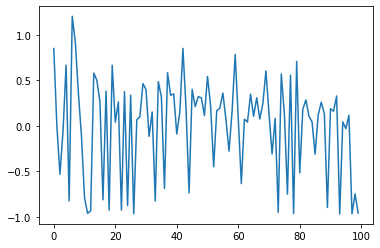

In [126]:
plt.plot(range(0,len(t_error)),t_error)

In [43]:
t_error

[array([ 0.15910304, -0.34140705,  0.56557833,  0.02769688, -0.10467275,
        -0.29805051,  0.32630962, -0.01793725]),
 array([ 0.01426139, -0.02414401,  0.04348442,  0.00204778, -0.00723449,
        -0.01718855,  0.06084006, -0.00229417]),
 array([ 0.12148092, -0.43041876,  0.31204626,  0.02845957, -0.11443338,
        -0.09797923,  0.18071477, -0.05523455]),
 array([ 0.07741748, -0.11958703,  0.18975244,  0.01081603, -0.04121697,
        -0.08018457,  0.17970264, -0.01028842]),
 array([ 0.05861503, -0.17231666,  0.21325161,  0.01528366, -0.04023269,
        -0.08478163,  0.09349022, -0.00415939]),
 array([ 0.10655741, -0.26745806,  0.20893658,  0.01423291, -0.02596871,
        -0.08205099,  0.13307976, -0.01079162]),
 array([ 0.13569871, -0.26970377,  0.49793973,  0.02547027, -0.09974643,
        -0.26022675,  0.31634782, -0.01329566]),
 array([ 0.20107255, -0.4151793 ,  0.63146953,  0.03525957, -0.12310166,
        -0.32464302,  0.4007561 , -0.02407988]),
 array([ 0.04466992, -0.

In [40]:
numpy.random.seed(0)
nn = my_MLP([2,2,1])

# Set the input data
X = numpy.array([[0, 0], [0, 1],
                [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = numpy.array([0, 1, 1, 0])

# Call the fit function and train the network for a chosen number of epochs
nn.fit(X, y, epochs=100000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, nn.predict_single_data(s))

epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
epochs: 50000
epochs: 60000
epochs: 70000
epochs: 80000
epochs: 90000
epochs: 100000
Final prediction
(array([0, 0]), 2.769390318381638e-05)
(array([0, 1]), 0.995154295769496)
(array([1, 0]), 0.9951532983339083)
(array([1, 1]), 2.783428053814478e-05)


In [34]:
numpy.random.seed(0)
nn = my_MLP([2,6,1])

# Set the input data
X = numpy.array([[0, 0], [0, 1],
                [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = numpy.array([0, 1, 1, 0])

# Call the fit function and train the network for a chosen number of epochs
nn.fit(X, y, epochs=100000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, nn.predict_single_data(s))

epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
epochs: 50000
epochs: 60000
epochs: 70000
epochs: 80000
epochs: 90000
epochs: 100000
Final prediction
(array([0, 0]), 4.937191807404877e-06)
(array([0, 1]), 0.9942401208448384)
(array([1, 0]), 0.9945517089211744)
(array([1, 1]), 9.290021024179977e-06)


In [11]:
xt,yt = sample_points(4)

In [34]:
numpy.random.seed(0)
nn = my_MLP([2,8,1])
xt,yt = sample_points(10000)
xv,yv = sample_points(2000)
t_error,v_error = nn.fit(xt,yt,xv,yv)


 30%|███       | 30/100 [00:00<00:00, 209.99it/s]

epochs: 10
epochs: 20
epochs: 30
epochs: 40
epochs: 50


 90%|█████████ | 90/100 [00:00<00:00, 216.31it/s]

epochs: 60
epochs: 70
epochs: 80
epochs: 90
epochs: 100


100%|██████████| 100/100 [00:00<00:00, 217.10it/s]


In [35]:
v_error

[1.159868190151853,
 1.090858732527839,
 0.9816567856913672,
 0.8806820194941529,
 0.7861764372277111,
 0.5651481287804668,
 0.43401960864444256,
 0.311607431969859,
 0.25510108435056905,
 0.14915495637969364]

In [37]:
t_error[0].shape

(8,)

In [13]:
xt.shape

(4, 2)

In [10]:
yu = yt[2]
yu[-1]

IndexError: invalid index to scalar variable.

In [60]:
a = [0,1,2,3]
a[-1]

3